# Demo example

Date: 27-09-2024

Author: Martin Proks

In [1]:
!export CUDA_VISIBLE_DEVICES=1

In [2]:
from scvi.hub import HubModel
from numba.core.errors import NumbaDeprecationWarning

import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

In [3]:
from scanvi_explainer import SCANVIDeep, SCANVIBoostrapper
from scanvi_explainer.plots import feature_plot

In [4]:
hmo = HubModel.pull_from_huggingface_hub(
    repo_name="brickmanlab/mouse-scanvi",
    cache_dir="/tmp/mouse_scanvi",
    revision="v1.0",
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
lvae = hmo.model
lvae

INFO     Loading model...                                                                                          


Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File                                                                                                      
         /tmp/mouse_scanvi/models--brickmanlab--mouse-scanvi/snapshots/122feddff5447c62e8a0b320650dbb6c7a1d764a/mod
         el.pt already downloaded                                                                                  


/home/fdb589/Brickman/github/scanvi-explainer/.venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/fdb589/Brickman/github/scanvi-explainer/.venv/ ...
/home/fdb589/Brickman/github/scanvi-explainer/.venv/lib/python3.10/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects wil

ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: False

In [6]:
e = SCANVIDeep(lvae, train_size=0.8, batch_size=128)
e

SCANVIDeep with the following parameters:
train_size=0.8, test_size=0.2, batch_size=128, labels_key=ct, layers_key=counts
training_on=cuda:0

In [7]:
shap_values = e.shap_values()

  0%|          | 0/15 [00:00<?, ?it/s]

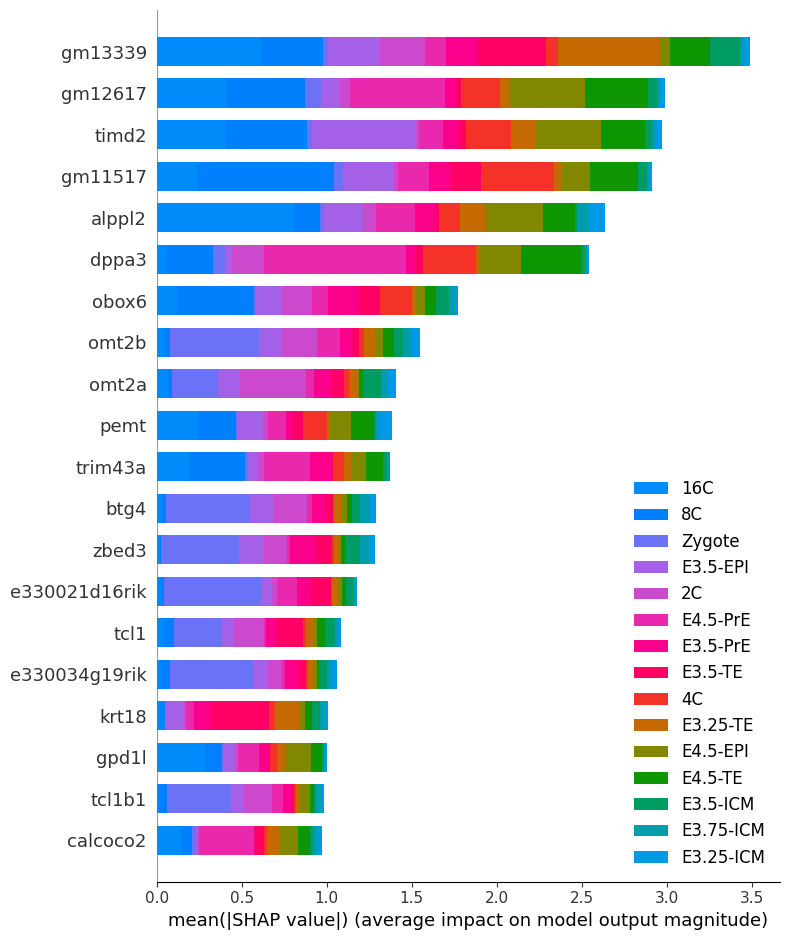

In [8]:
import shap


shap.summary_plot(
    shap_values,
    e.test['X'],
    feature_names=lvae.adata.var_names, 
    class_names=lvae.adata.obs.ct.cat.categories
)

In [9]:
lvae.adata.var

,gene_ids,gene_symbol,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
sox17,ENSMUSG00000025902,Sox17,False,641,20.303165,68.298714,41053.0,641,True,0.383795,0.916023,3.415429,7,False
ppp1r42,ENSMUSG00000025916,Ppp1r42,False,50,0.649357,97.527201,1313.0,50,True,0.010606,0.317620,1.000011,4,False
arfgef1,ENSMUSG00000067851,Arfgef1,False,1595,200.979723,21.117705,406381.0,1595,True,1.193781,0.573535,1.177822,4,False
prdm14,ENSMUSG00000042414,Prdm14,False,639,18.401088,68.397626,37207.0,639,True,0.333239,0.770153,1.246952,4,False
xkr9,ENSMUSG00000067813,Xkr9,False,327,12.995054,83.827893,26276.0,327,True,0.222491,0.630573,1.196979,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
habp2,ENSMUSG00000025075,Habp2,False,158,2.715628,92.185955,5491.0,158,True,0.059447,0.638976,1.476901,3,False
ccdc186,ENSMUSG00000035173,Ccdc186,False,1231,331.236400,39.119683,669760.0,1231,True,1.094922,0.594682,1.020226,4,False
afap1l2,ENSMUSG00000025083,Afap1l2,False,251,56.485658,87.586548,114214.0,251,True,0.275932,0.754868,1.354747,5,False
pnlip,ENSMUSG00000046008,Pnlip,False,140,2.630564,93.076162,5319.0,140,True,0.041573,0.695832,0.864209,4,False


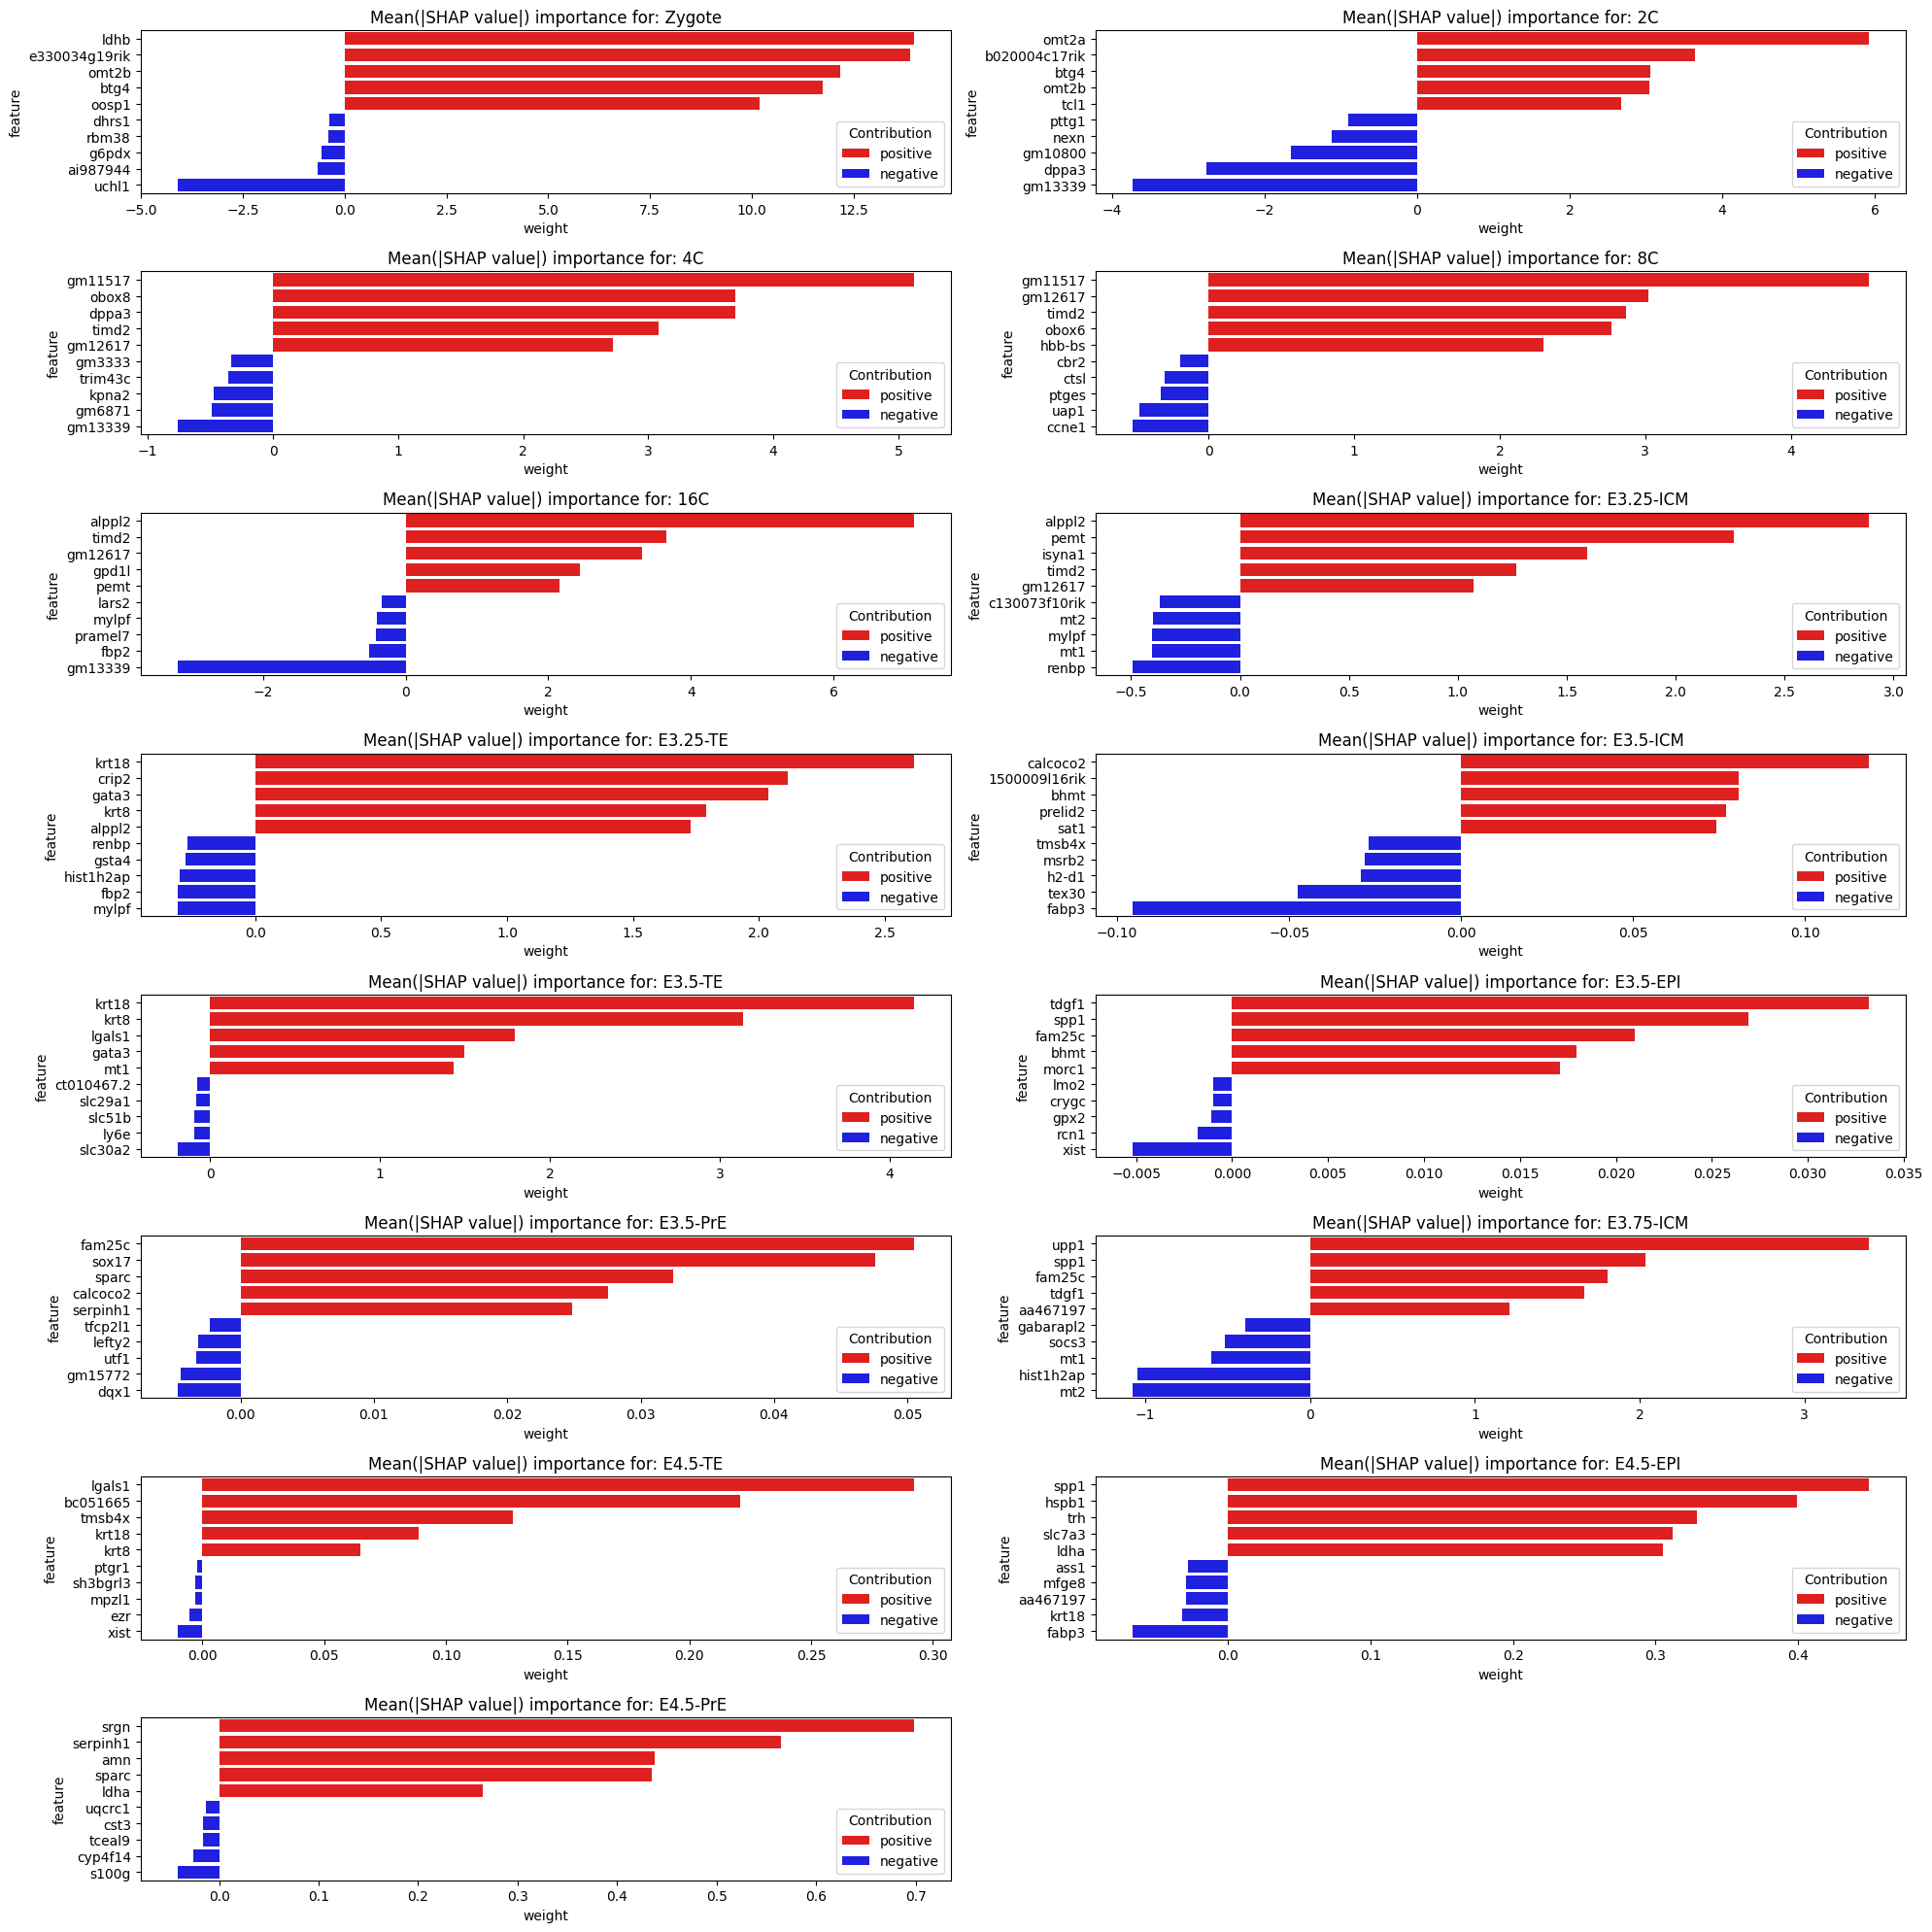

In [10]:
feature_plot(e, shap_values, subset=True, top_n=10)

## Bootstrapper

In order to strenghten the predicted features (genes), we have also implemented
bootstrapping approach. The plots below calculates $\mu$ value of each bootstrap.
To adjust parameters, please refer to the documentation.

In [11]:
bootstrapper = SCANVIBoostrapper(lvae, n_bootstraps=10)

In [12]:
shap_values = bootstrapper.run(train_size=0.8, batch_size=64)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [14]:
bootstrapper.save(shap_values, './bootstrapped_shaps.feather')

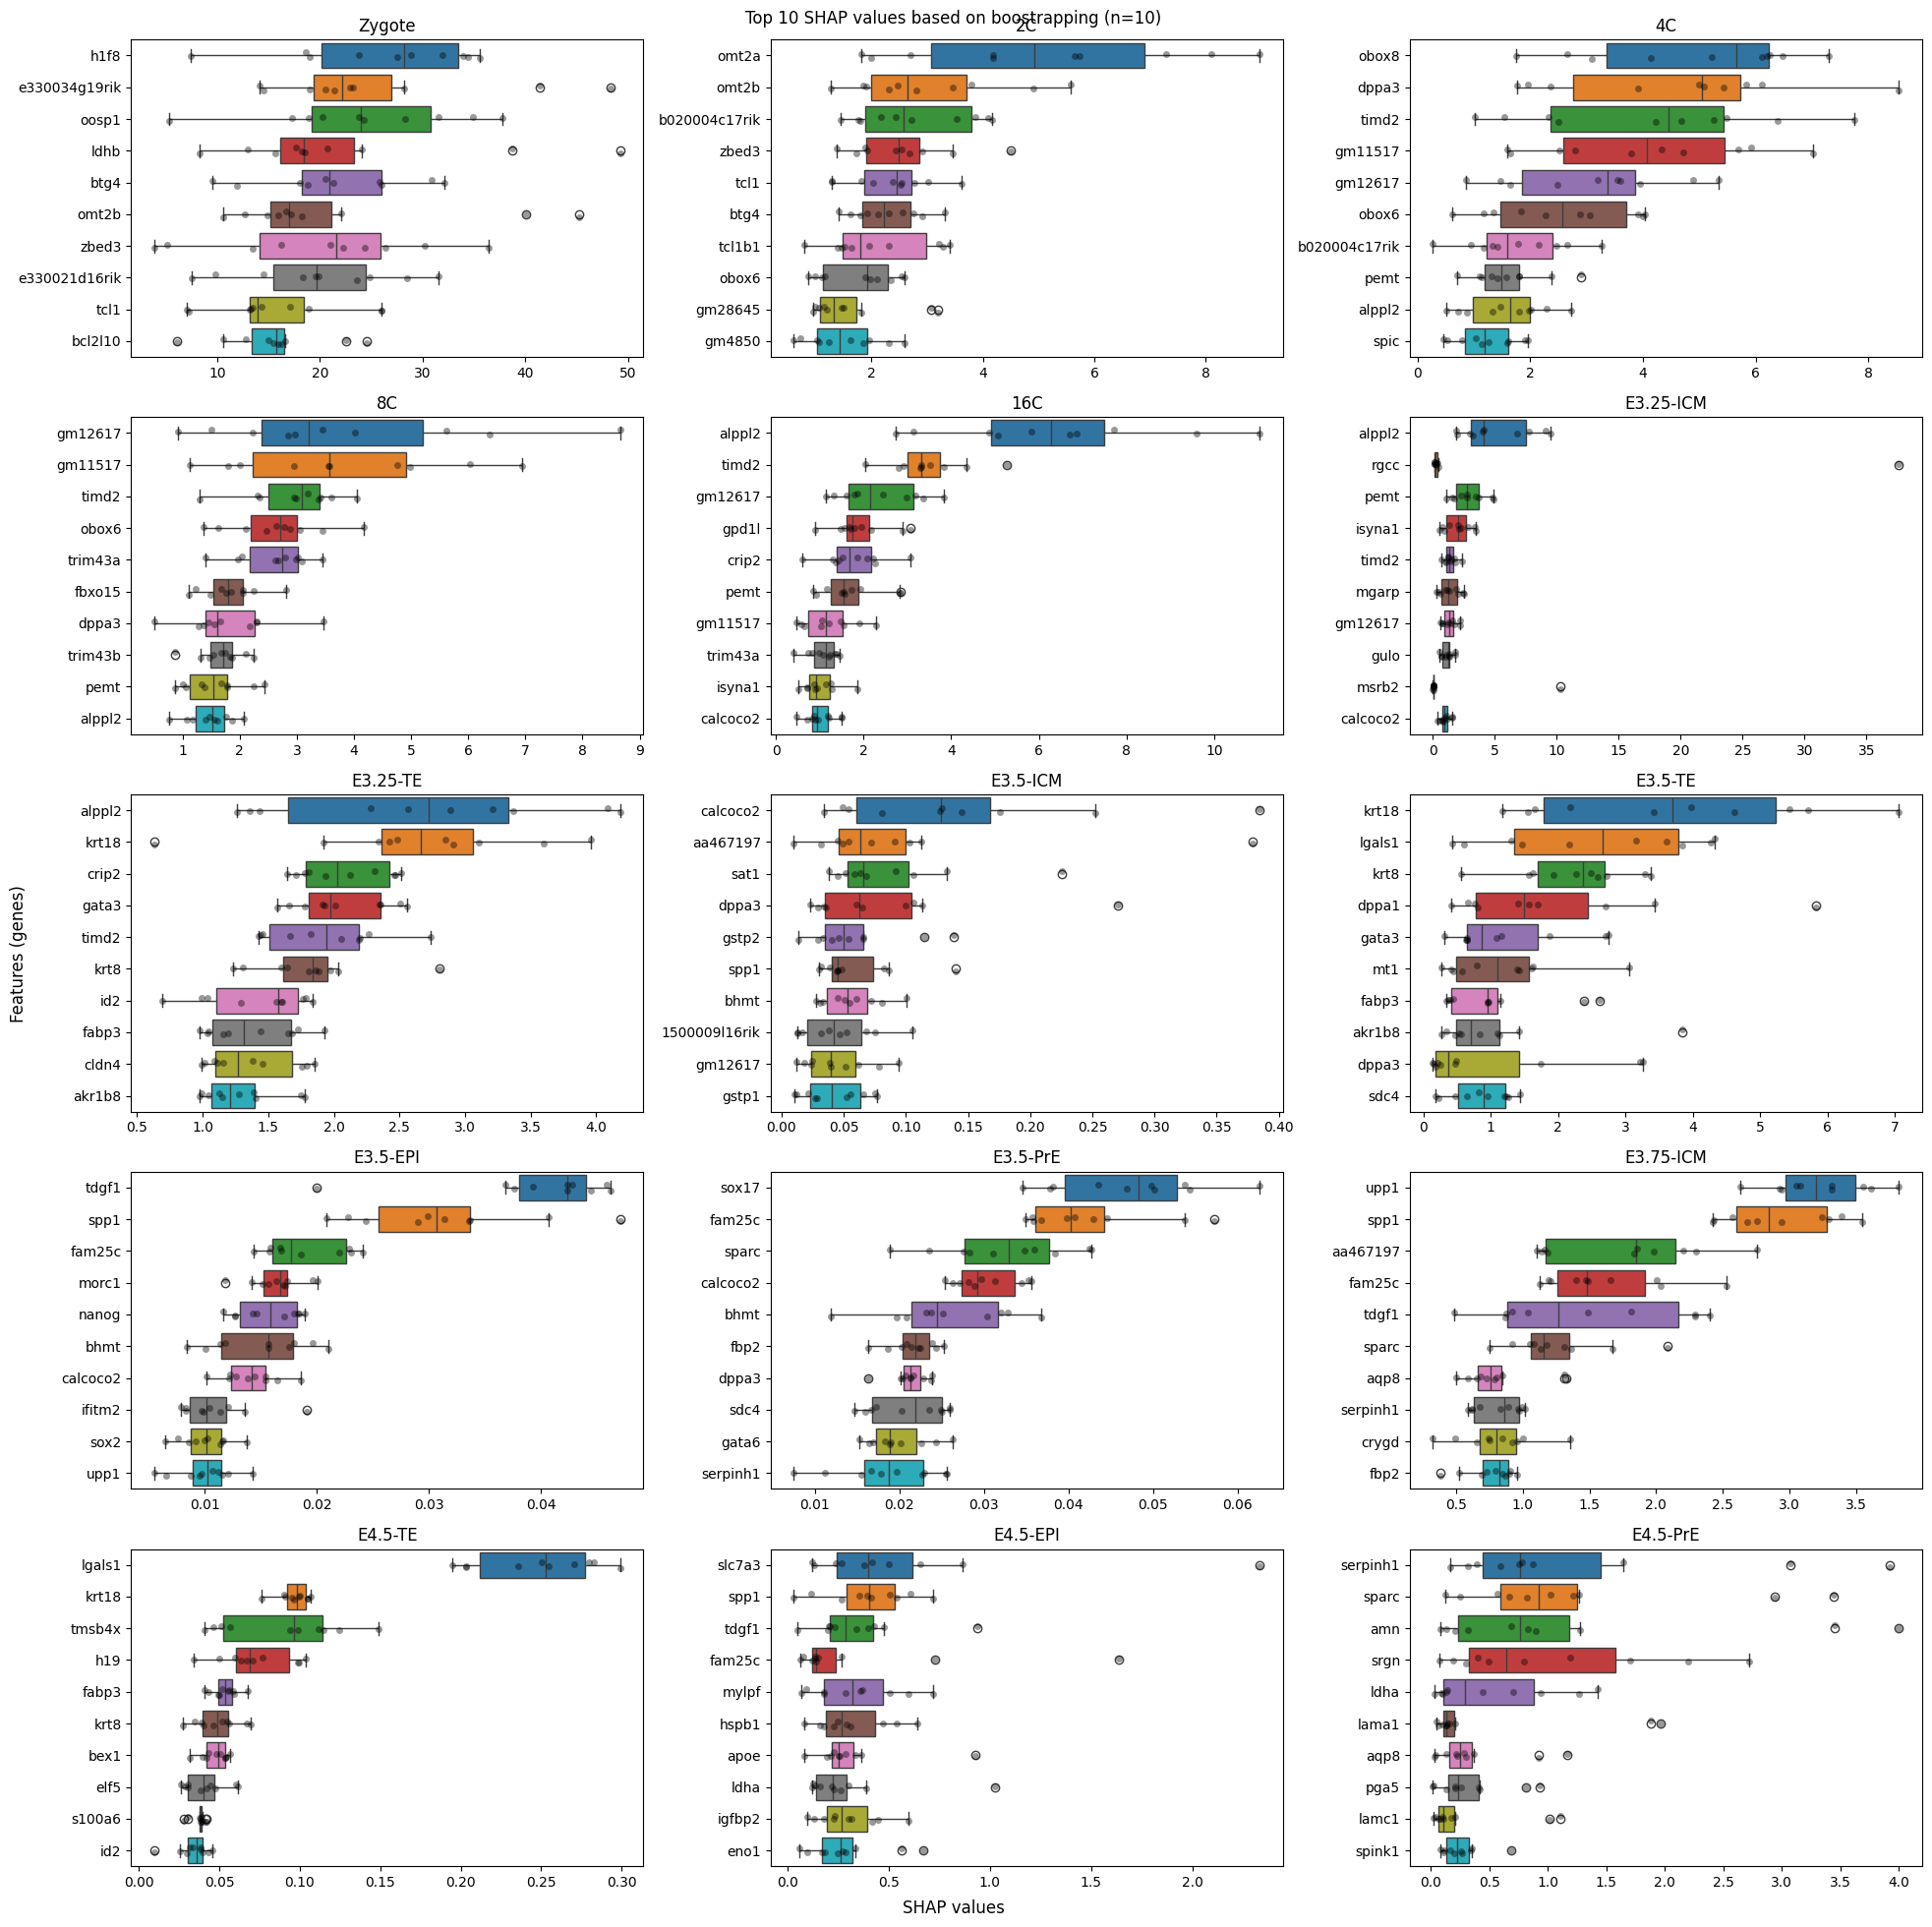

In [15]:
bootstrapper.feature_plot(shap_values)

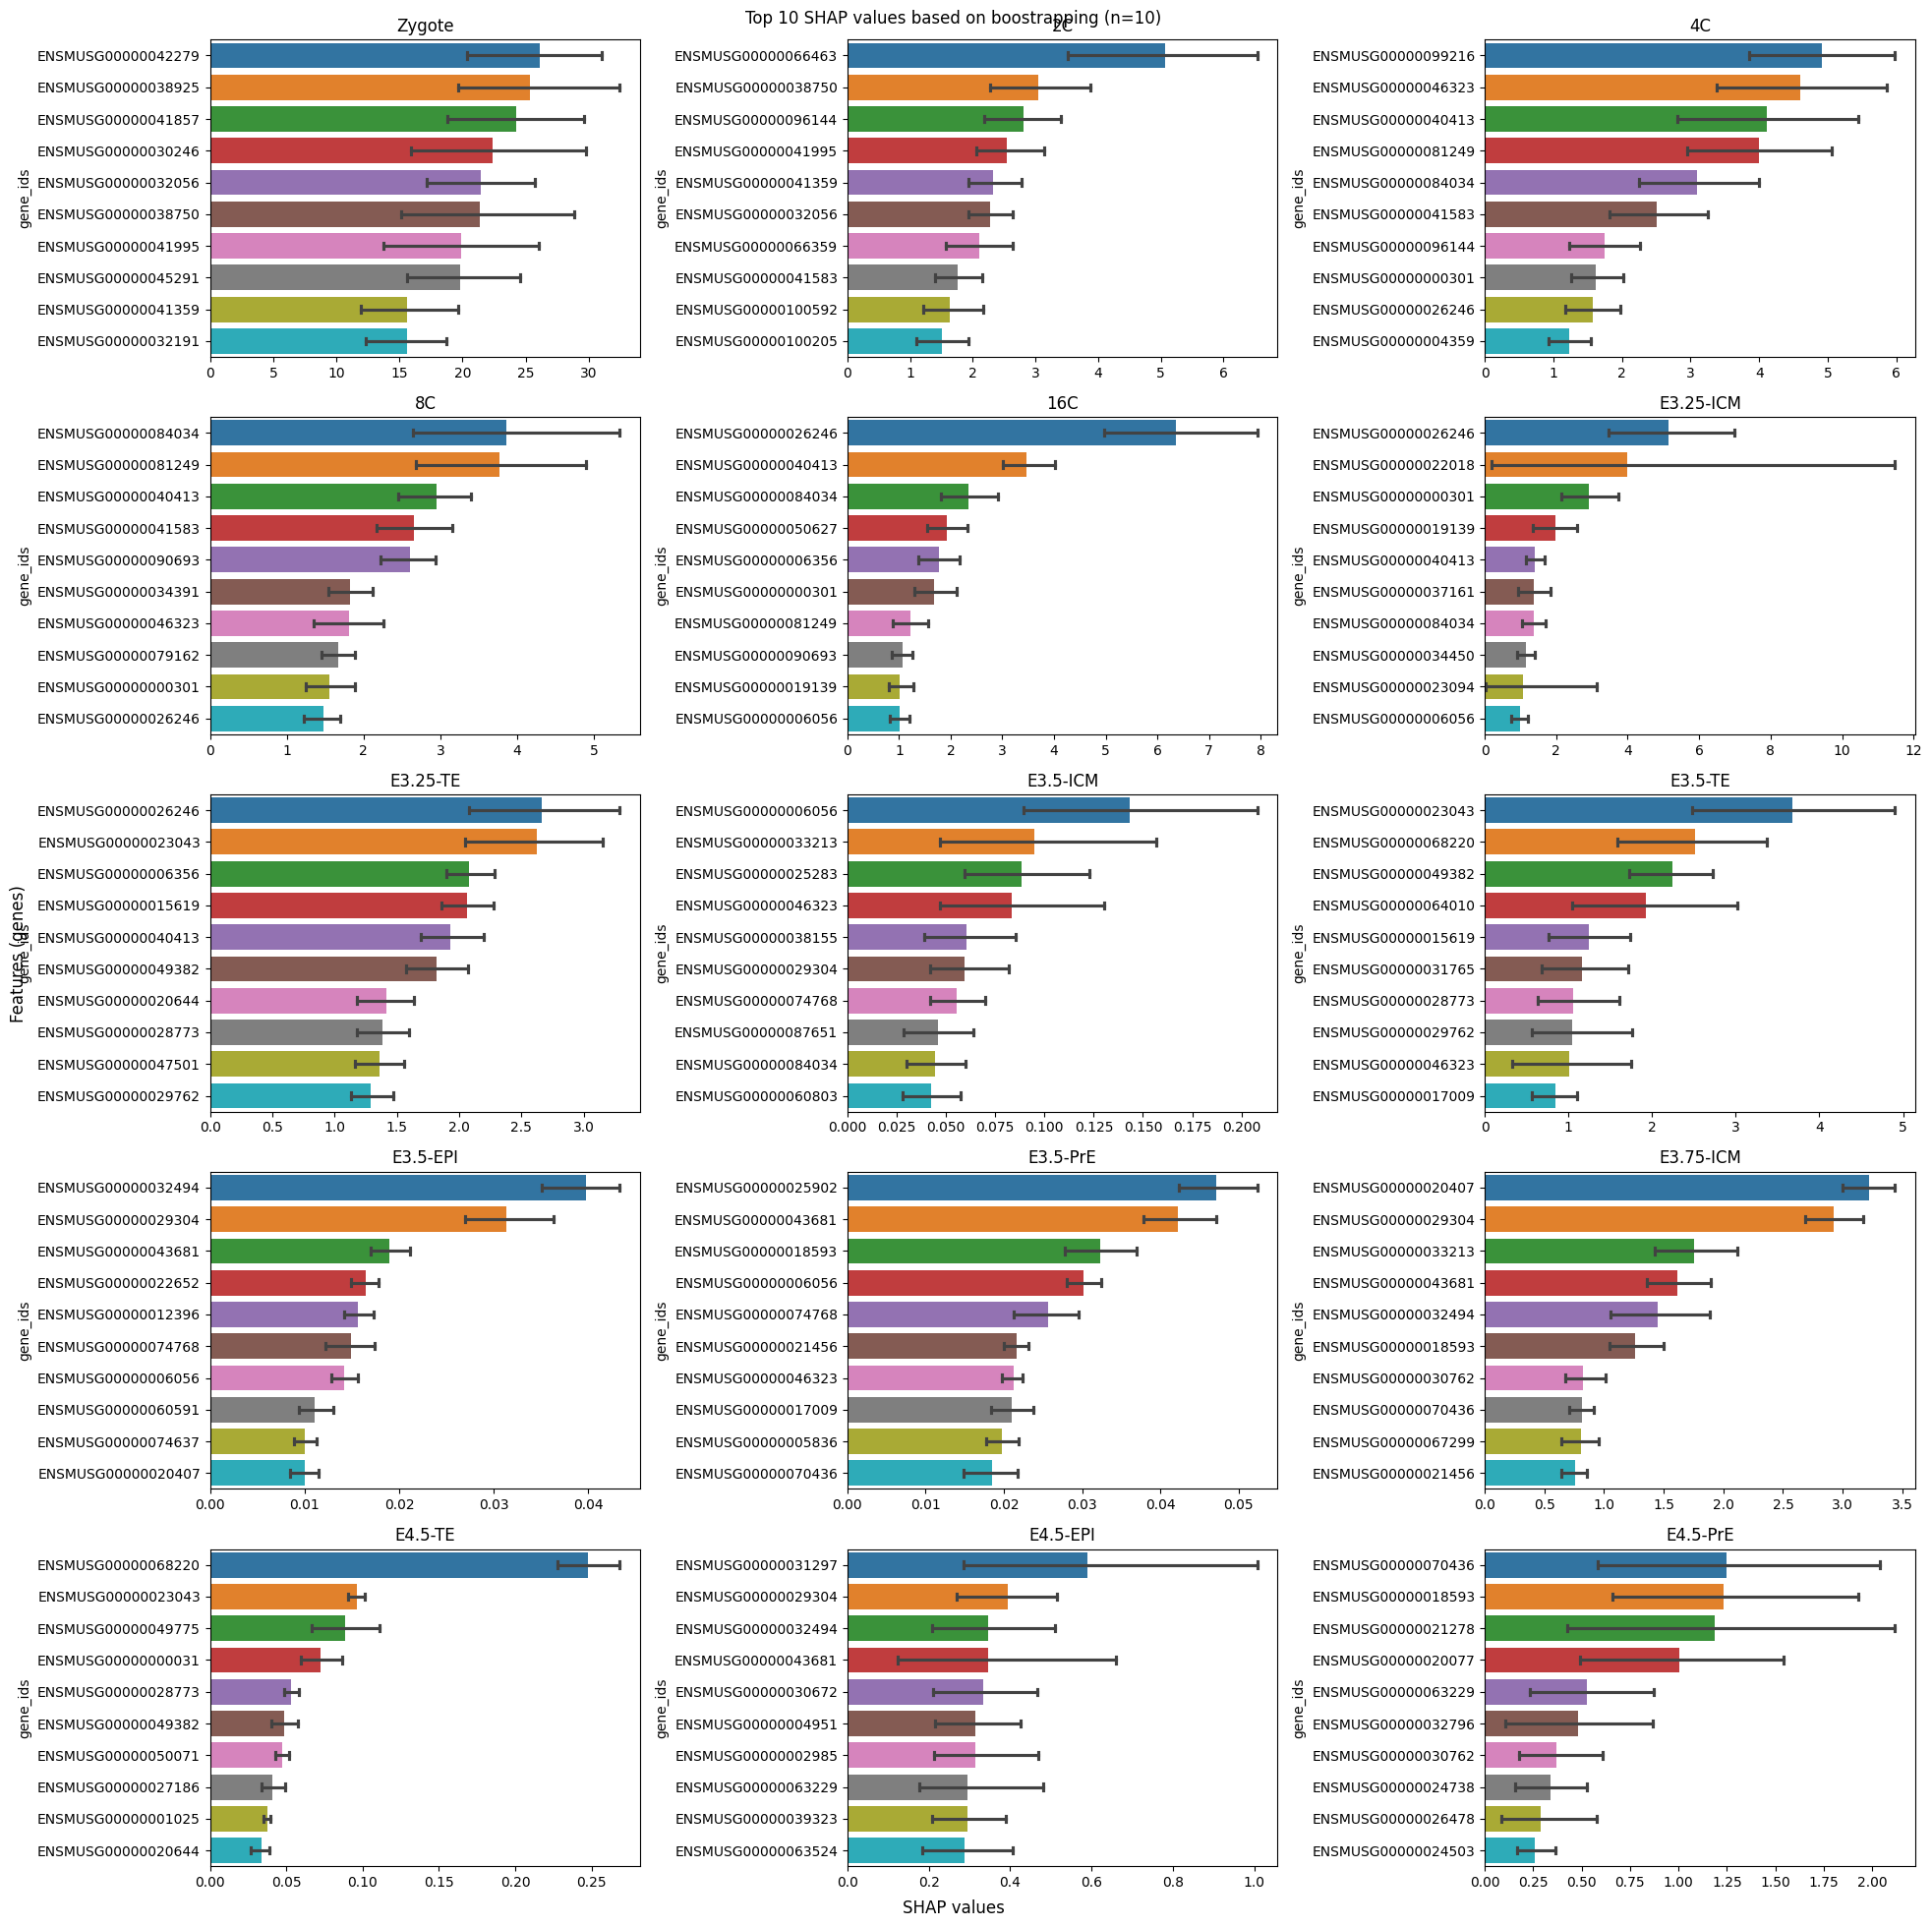

In [18]:
bootstrapper.feature_plot(shap_values, kind="barplot", gene_symbols='gene_ids')